# Homework part II

### Deep crossentropy method

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to upload the result and get to something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ __(5 pts)__ Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ __(bonus: 5 pts each)__ Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params), show graphs for different params
  
  
### Tips
* Gym page: [mountaincar](https://gym.openai.com/envs/MountainCar-v0), [lunarlander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. 
* 20-neuron network is probably not enough, feel free to experiment.

In [1]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
env = gym.make("MountainCar-v0").env #choose 1 env - for example: gym.make("MountainCar-v0").env
env.reset()
n_actions = env.action_space.n

D:\anaconda3\Lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
def generate_session(t_max=10000):
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    
    for t in range(t_max):
        try:
            probs = agent.predict_proba([s.tolist()])[0]
        except Exception:
            probs = [1. / n_actions for i in range(n_actions)]
        
        a = np.random.choice(np.arange(n_actions), p=probs)
        
        new_s,r,done,info = env.step(a)
        
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done: break
    return states,actions,total_reward
        

In [3]:
#create agent
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20,20),#(experiment with layers size),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )

In [4]:
from IPython.display import clear_output

def show_progress(rewards_batch,log,percentile=40, reward_range=[-5000,+5000]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch,percentile)
    log.append([mean_reward,threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward,threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0],label='Mean rewards')
    plt.plot(list(zip(*log))[1],label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    #print(rewards_batch)
    reward_range=[-1010,+10]
    plt.hist(rewards_batch,range=reward_range);
    plt.vlines([np.percentile(rewards_batch,percentile)],[0],[100],label="percentile",color='red')
    plt.legend()
    plt.grid()

    plt.show()


In [5]:
def select_elites(states_batch,actions_batch,rewards_batch,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """ 
    reward_threshold = np.percentile(rewards_batch, percentile) #recalc threshold. hint : np.percentile
    
    elite_states = []
    elite_actions = []
    
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.append(states_batch[i])
            elite_actions.append(actions_batch[i])
    
    if(len(np.array(elite_states[0]).shape) == 1):
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)
    elite_actions = np.hstack(elite_actions)
    
    return elite_states,elite_actions

mean reward = -147.940, threshold=-144.000


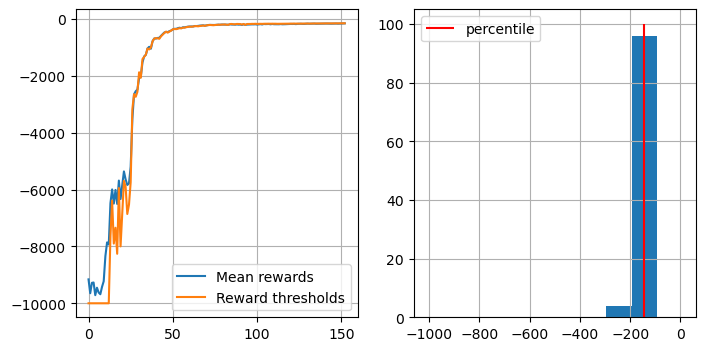

Win!
Time: 1766.3611557483673


In [6]:
# просто запуск
import time
n_sessions = 100
percentile = 40
log = []
startTime = time.time()

for i in range(10000):
    sessions = [generate_session() for _ in range(n_sessions)]

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile=percentile)
    
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,percentile)
    
    if np.array(rewards_batch).mean() >= -150:
        print("Win!")
        break

print("Time:", time.time() - startTime)

mean reward = -149.100, threshold=-149.000


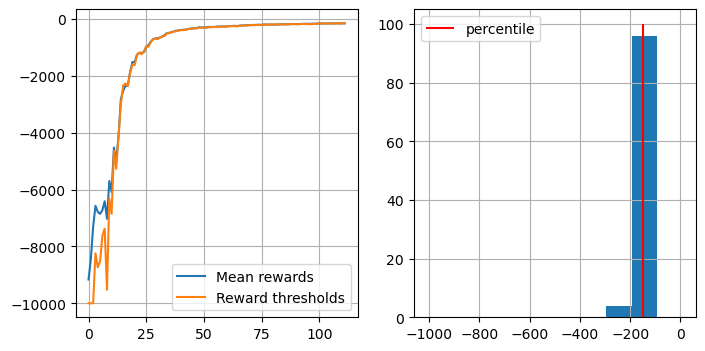

Win!
Time: 216.72455167770386


In [14]:
# запуск с joblib

import time
from joblib import Parallel, delayed
n_sessions = 100
percentile = 40
log = []
startTime = time.time()

for i in range(10000):
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)() for i in range(n_sessions))

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,percentile=percentile)
    
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,percentile)
    
    if np.array(rewards_batch).mean() >= -150:
        print("Win!")
        break

print("Time:", time.time() - startTime)

In [6]:
def select_elites(states_batch,actions_batch,rewards_batch,last_rewards,percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """ 
    reward_threshold = np.percentile(last_rewards, percentile) #recalc threshold. hint : np.percentile
    
    elite_states = []
    elite_actions = []
    
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.append(states_batch[i])
            elite_actions.append(actions_batch[i])
    
    if(len(np.array(elite_states[0]).shape) == 1):
        elite_states = np.hstack(elite_states)
    else:
        elite_states = np.vstack(elite_states)
    elite_actions = np.hstack(elite_actions)
    
    return elite_states,elite_actions

mean reward = -149.670, threshold=-144.000


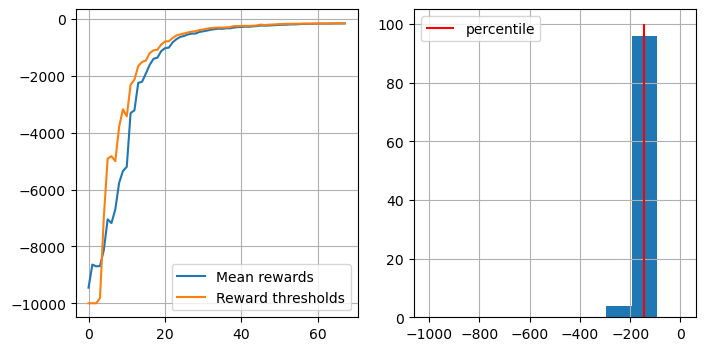

Win!
Time: 163.0144670009613


In [7]:
# запуск с joblib и re-using 

import time
from joblib import Parallel, delayed
n_sessions = 100
percentile = 70
log = []
startTime = time.time()


last_states = []
last_actions = []
last_rewards = []
cnt = []

for i in range(10000):
    sessions = Parallel(n_jobs=-1)(delayed(generate_session)() for i in range(n_sessions))

    states_batch,actions_batch,rewards_batch = zip(*sessions)

    if len(cnt) >= 5:
        last_states = last_states[cnt[0]:]
        last_actions = last_actions[cnt[0]:]
        last_rewards = last_rewards[cnt[0]:]
        cnt = cnt[1:]
    for i in states_batch:
        last_states.append(i)
    for i in actions_batch:
        last_actions.append(i)
    for i in rewards_batch:
        last_rewards.append(i)
    cnt.append(len(states_batch))
    
    elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,last_rewards,percentile=percentile)
    
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch,log,percentile)
    
    if np.array(rewards_batch).mean() >= -150:
        print("Win!")
        break

print("Time:", time.time() - startTime)

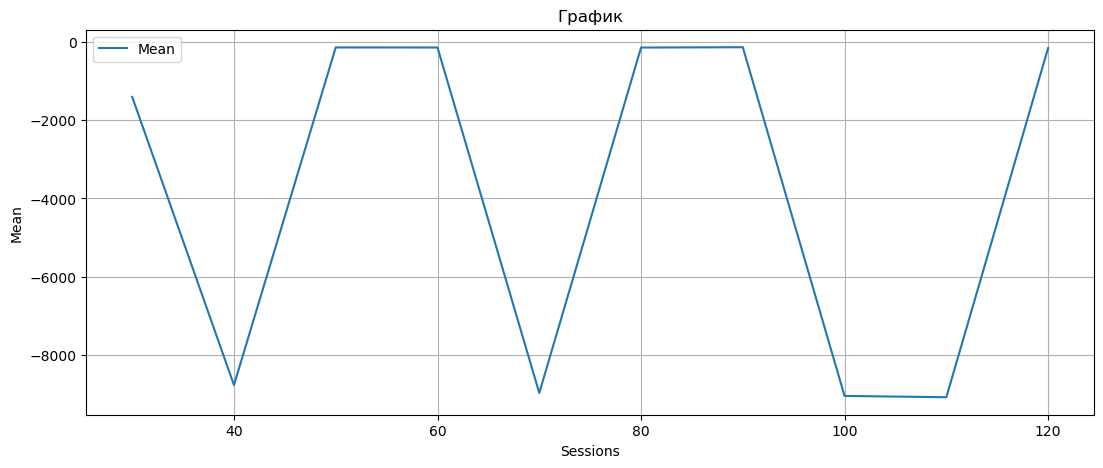

In [7]:
import time
from joblib import Parallel, delayed

n_sessions_ar = [i for i in range(20, 121, 20)]  #sample this many sessions
percentile = 70  #take this percent of session with highest rewards

log = []
mean = []
for n_sessions in n_sessions_ar:
    curMean = []
    agent = MLPClassifier(hidden_layer_sizes=(20,20),#(experiment with layers size),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
    last_states = []
    last_actions = []
    last_rewards = []
    cnt = []
    for _ in range(80):
        sessions = Parallel(n_jobs=-1)(delayed(generate_session)() for i in range(n_sessions))

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        if len(cnt) >= 5:
            last_states = last_states[cnt[0]:]
            last_actions = last_actions[cnt[0]:]
            last_rewards = last_rewards[cnt[0]:]
            cnt = cnt[1:]
        for i in states_batch:
            last_states.append(i)
        for i in actions_batch:
            last_actions.append(i)
        for i in rewards_batch:
            last_rewards.append(i)
        cnt.append(len(states_batch))

        elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,last_rewards,percentile=percentile)

        agent.fit(elite_states, elite_actions)
        
        last_rewards_np = np.array(last_rewards)
        curMean.append(np.mean(last_rewards_np[last_rewards_np >= np.percentile(last_rewards_np, percentile)]))
        clear_output(True)
        print(n_sessions, _, curMean[-1])
    mean.append(curMean)

clear_output(True)
f, (ax) = plt.subplots(1, 1, figsize=(13, 5))
for i in range(len(mean)):
    ax.plot(np.arange(stepCounter) + 1, np.array(mean[i]), label="n_sessions = "+str(n_sessions_ar[i]))
    ax.set_title(u"График")
    ax.set_xlabel(u"Iterations")
    ax.set_ylabel(u"Mean")
ax.grid()
ax.legend()

In [8]:
print(mean)

[-1407.4222222222222, -8767.515, -143.4731182795699, -145.07692307692307, -8968.785714285714, -146.4822695035461, -137.85897435897436, -9045.27, -9078.185454545455, -159.78333333333333]


0.01 79 -157.08
[-9441.67, -236.29605263157896, -137.03592814371257, -9177.21, -138.91228070175438, -141.45977011494253, -9072.14, -137.6969696969697, -5643.873333333333]


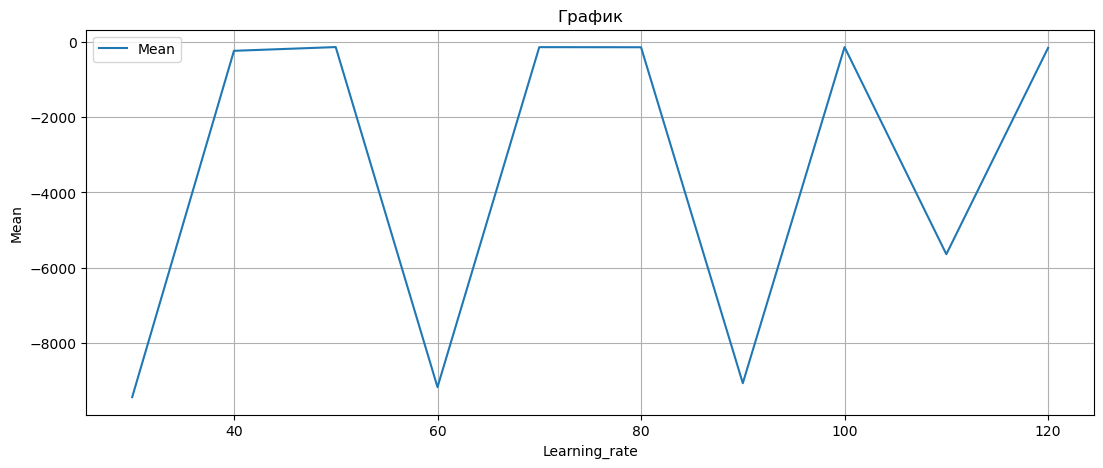

In [9]:
import time
from joblib import Parallel, delayed

n_sessions = 100  #sample this many sessions
percentile = 70  #take this percent of session with highest rewards
learning_rate_ar = [i / 1000 for i in range(1, 11)]

log = []
mean = []
for learning_rate in learning_rate_ar:
    curMean = []
    agent = MLPClassifier(hidden_layer_sizes=(20,20),#(experiment with layers size),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1,#make only 1 iteration on each .fit(...)
                      learning_rate_init=learning_rate)
    last_states = []
    last_actions = []
    last_rewards = []
    cnt = []
    for i in range(80):
        sessions = Parallel(n_jobs=-1)(delayed(generate_session)() for i in range(n_sessions))

        states_batch,actions_batch,rewards_batch = zip(*sessions)

        if len(cnt) >= 5:
            last_states = last_states[cnt[0]:]
            last_actions = last_actions[cnt[0]:]
            last_rewards = last_rewards[cnt[0]:]
            cnt = cnt[1:]
        for i in states_batch:
            last_states.append(i)
        for i in actions_batch:
            last_actions.append(i)
        for i in rewards_batch:
            last_rewards.append(i)
        cnt.append(len(states_batch))

        elite_states, elite_actions = select_elites(states_batch,actions_batch,rewards_batch,last_rewards,percentile=percentile)

        agent.fit(elite_states, elite_actions)
        
        last_rewards_np = np.array(last_rewards)
        curMean.append(np.mean(last_rewards_np[last_rewards_np >= np.percentile(last_rewards_np, percentile)]))

        clear_output(True)
        print(learning_rate, _, curMean[-1])
        print(mean)
    mean.append(max(curMean))


f, (ax) = plt.subplots(1, 1, figsize=(13, 5))
ax.plot(n_sessions_ar, np.array(mean), label=u"Mean")
ax.set_title(u"График")
ax.set_xlabel(u"Learning_rate")
ax.set_ylabel(u"Mean")
ax.grid()
ax.legend()